In [1]:
import spot
spot.setup()
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
help(spot.translate)

Help on function translate in module spot:

translate(formula, *args, dict=<spot.impl.bdd_dict; proxy of <Swig Object of type 'std::shared_ptr< spot::bdd_dict > *' at 0x7f897b26cc60> >, xargs=None)
    Translate a formula into an automaton.
    
    Keep in mind that 'Deterministic' expresses just a preference that
    may not be satisfied.
    
    The optional arguments should be strings among the following:
    - at most one in 'TGBA', 'BA', or 'Monitor', 'generic',
      'parity', 'parity min odd', 'parity min even',
      'parity max odd', 'parity max even' (type of automaton to
      build), 'coBuchi'
    - at most one in 'Small', 'Deterministic', 'Any'
      (preferred characteristics of the produced automaton)
    - at most one in 'Low', 'Medium', 'High'
      (optimization level)
    - any combination of 'Complete', 'Unambiguous',
      'StateBasedAcceptance' (or 'SBAcc' for short), and
      'Colored' (only for parity acceptance)
    
    The default corresponds to 'tgba', 's

In [3]:
# specifying reactive success criteria for scooping task in linear temporal logic
scoop_ltl = spot.formula('a & G Fd & G(a <-> (!r & !s & !t)) & G(b <->(r& !s & !t)) & G(c<-> (!r & s & !t)) & G(d<-> (!r&s&t)) & G((a&!b&!c&!d) | (!a&b&!c&!d) | (!a&!b&c&!d) | (!a&!b&!c&d)) & G(a->(Xa | Xb)) & G(b->(Xb|Xc|Xa)) & G(c->(Xa|Xb|Xc|Xd)) & G(d->(Xd))')
scoop_ltl
# atomic propositions (AP) a, b, c, d correspond to free mode, scooping mode, transfer mode, and done mode. 
# Boolean AP r, s, t denote sensing the spoon reaching the soup, soup on the spoon, and task success respectively.

spot.formula("a & GFd & G(a <-> (!r & !s & !t)) & G(b <-> (r & !s & !t)) & G(c <-> (!r & s & !t)) & G(d <-> (!r & s & t)) & G((a & !b & !c & !d) | (!a & b & !c & !d) | (!a & !b & c & !d) | (!a & !b & !c & d)) & G(a -> (Xa | Xb)) & G(b -> (Xa | Xb | Xc)) & G(c -> (Xa | Xb | Xc | Xd)) & G(d -> Xd)")

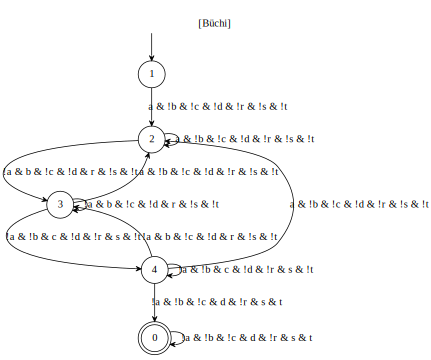

In [4]:
# spot translates LTL to an actionable automaton
a = spot.translate(scoop_ltl, 'ba', 'small', 'high');
a.show('v')

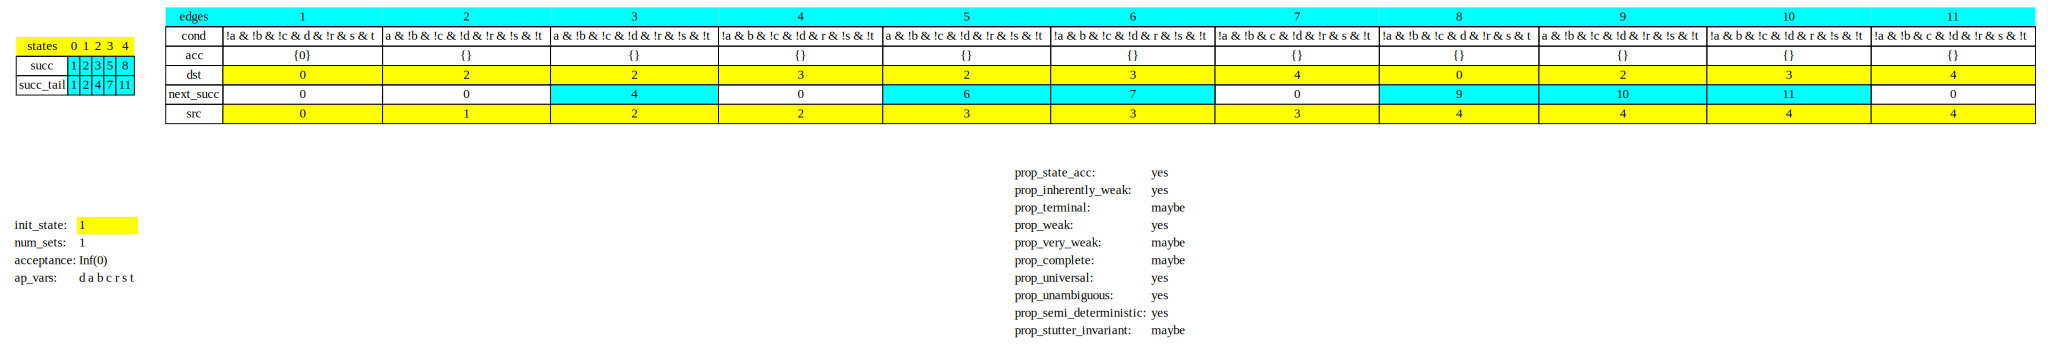

In [5]:
# how spot stores automaton structure
a.show_storage()

In [6]:
# list of atomic propositions
APs = sorted([str(p) for p in a.ap()]) 
APs

['a', 'b', 'c', 'd', 'r', 's', 't']

In [7]:
# we know how to split APs into robot and env APs since the formula is given by humans
robot_APs = APs[:4] # [a, b, c, d]
env_APs = APs[4:] # [r, s, t]
# map numeric index of a node to a robot AP
node_to_mode = {}
for i in range(a.num_edges()): 
    edge = a.edge_storage(i+1) # 1 indexed
    destination_node = edge.dst
    bdd = spot.bdd_format_formula(a.get_dict(), edge.cond)
    for p in robot_APs: # only one robot_ap will be true, i.e. one and only one mode at a time
        if '!'+p in bdd: # false assignment to p
            pass
        else: # true assignment to p. If p is not in bdd, we assume p has been and stays true
            node_to_mode[destination_node] = p
node_to_mode[1] = 'a' # since node 1 is a placeholder, we add it to the starting mode
node_to_mode

{0: 'd', 2: 'a', 3: 'b', 4: 'c', 1: 'a'}

In [8]:
# extracting the spot automaton into an operationable dictionary
automaton_dict = {} 
for mode in robot_APs:
    automaton_dict[mode] = {}
    
# polulate automaton_dict with transitions in spot automaton
for i in range(a.num_edges()): 
    edge = a.edge_storage(i+1) # 1 indexed
    source_node = edge.src
    bdd = spot.bdd_format_formula(a.get_dict(), edge.cond)
    for p in robot_APs: # only one robot_ap will be true, i.e. one and only one mode at a time
        if '!'+p in bdd: # false assignment to p
            pass
        else: # true assignment to p. If p is not in bdd, we assume p has been and stays true
            sensor_vec = ''
            for q in env_APs:
                if '!'+q in bdd:
                    sensor_vec+='0'
                else:
                    sensor_vec+='1'
            automaton_dict[node_to_mode[source_node]][sensor_vec] = p

automaton_dict

{'a': {'000': 'a', '100': 'b'},
 'b': {'000': 'a', '100': 'b', '010': 'c'},
 'c': {'011': 'd', '000': 'a', '100': 'b', '010': 'c'},
 'd': {'011': 'd'}}

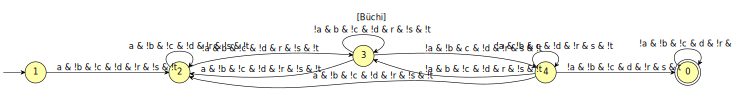

In [9]:
a.show() # where number 2, 3, 4, 0 correspond to mode a, b, c, d; number 1 is a placeholder for starting in mode a

In [10]:
def simulate(A, desired_plan, init_mode):
    # simulate a receding horizon controller at the discrete mode level
    # given an automaton A, this function generates a reactive plan despite task-level perturbations
    
    curr_mode = init_mode
    history = curr_mode
    while True:
        print('Activating continuous policy associated with mode ' + curr_mode +'...')
        # sample legal sensor measurements considering potential perturbations
        while True:
            sensor_measurement = random.sample(A[curr_mode].keys(), 1)[0]
            if curr_mode != A[curr_mode][sensor_measurement]: # remove self-transition to reduce printing clutter
                break
        curr_mode = A[curr_mode][sensor_measurement]
        history += '_' + sensor_measurement + '->' + curr_mode
        print('...'+history[-80:]+'\n')
        if curr_mode == desired_plan[-1]:
            break

In [11]:
# Let's define desired mode sequence as sensed in a successful demonstration of scooping
desired_plan = ['a', 'b', 'c', 'd']
init_mode = node_to_mode[a.get_init_state_number()]
simulate(automaton_dict, desired_plan, init_mode)

Activating continuous policy associated with mode a...
...a_100->b

Activating continuous policy associated with mode b...
...a_100->b_010->c

Activating continuous policy associated with mode c...
...a_100->b_010->c_100->b

Activating continuous policy associated with mode b...
...a_100->b_010->c_100->b_010->c

Activating continuous policy associated with mode c...
...a_100->b_010->c_100->b_010->c_011->d

